# Ngram2Vec 실행 코드 정리
* ngram2vec의 목적: 이를 바탕으로 한 감성사전 만들기!!!

## 1. 기사에 대한 라벨링
    1-1. 토큰화한 기사 파일
    1-2. 품사 정리

In [ ]:
# 1. 토큰화한 기사 파일 가져오기 (test용 chunck 1만)
import pandas as pd
import ast
from tqdm import tqdm
tqdm.pandas()
test = pd.read_csv(r'/content/drive/MyDrive/BOK-TEAM-2/데이터 전처리/이데일리/토큰자료/chunk_1.csv')
test['stopwords'] = test['stopwords'].apply(lambda x: ast.literal_eval(x))
# 2. 품사 정리해서 리스트 새로 만들기
ALLOWED_TAGS = {'NNG', 'VA', 'VAX', 'MAG', 'negations'}
test['stopwords'] = test['stopwords'].apply(lambda x: [word for word in x if word[1] in ALLOWED_TAGS])
test.head()
# 5000개에 13초 정도

def processChunk(chunk_num):
    chunk = pd.read_csv(f'/content/drive/MyDrive/BOK-TEAM-2/데이터 전처리/이데일리/토큰자료/chunk_{chunk_num}.csv')
    chunk['stopwords'] = chunk['stopwords'].apply(lambda x: ast.literal_eval(x))
    return chunk

def processChunckHK(chunk_num):
    chunk = pd.read_csv()
    chunk['tagged'] = chunk['tagged'].apply(lambda x: ast.literal_eval(x))
    chunk['tagged'] = chunk['tagged'].apply(lambda x: [word for word in x if word[1] in ALLOWED_TAGS])
    return chunk


## 2. ngram 데이터 준비
    2-1. 각 text에 대한 n-gram 추출 (1~5 gram)

In [ ]:
from collections import Counter
from tqdm import tqdm

def generate_ngrams(token_list, max_n=5):
    words = [token[0] for token in token_list]
    ngram_counter = Counter()
    for n in range(1, max_n + 1):
        ngrams = [tuple(words[i:i+n]) for i in range(len(words) - n + 1)]
        ngram_counter.update(ngrams)
    return ngram_counter

ngram_total = [generate_ngrams(text) for text in tqdm(test['stopwords'])]

# 5000개 2초

100%|██████████| 5000/5000 [00:02<00:00, 1770.53it/s]


## 3. N-gram 데이터를 통해 Word2Vec 데이터 학습 모델 형성
    3-1. 메모리를 잡아먹지 않도록 하나씩 문서를 처리하고 다음 문서를 불러옴
    3-2. 위의 N-gram과 합쳐서 코드 적어야 함
    3-3. 금리 상승 / 하락의 데이터 비율을 맞추어야 하지 않을까? (반반)
    3-4. 우선 벡터화가 목적이므로 **test set는 필요 없는가?**
    3-5. 분류 모델을 만들 때 (lexicon 형성 작업) 에서는 train , test가 필요한 것 아닌가? **-> 미리 라벨링 해 두어야 하나?**

### 이데일리 파일을 활용한 모델 학습
* 무조건 처음에 해야 함. 모델 초기화 해야 하기 때문에

In [3]:
import pandas as pd
from tqdm import tqdm
import ast
from gensim.models import Word2Vec
ALLOWED_TAGS = {'NNG', 'VA', 'VAX', 'MAG', 'negations'}

# n-gram 생성 함수
def generate_ngrams(token_list, max_n=5):
    words = [token[0] for token in token_list]  # 단어 리스트 추출
    ngram_list = []  # n-gram을 저장할 리스트
    for n in range(1, max_n + 1):  # 1-gram부터 max_n-gram까지
        ngrams = [' '.join(words[i:i+n]) for i in range(len(words) - n + 1)]  # n-gram을 문자열로 변환
        ngram_list.extend(ngrams)  # n-gram 리스트에 추가
    return ngram_list

# Word2Vec 모델 초기화
model = Word2Vec(vector_size=300,
                 window=5,
                 sg=1,
                 negative=5,
                 min_count= 5, # 모델 초기화할 때 다시 한 번 체크
                 # min_count 너무 작으면 RAM문제 생기는 듯, 따라서 빈도수 5 이하는 우선 버리고 진행한 뒤, 이후에 15개 이하인 vector를 다시 제거한다.
                 alpha=0.025,
                 min_alpha=0.0001, workers=3, epochs=10)
                # 해결법 1. worker 수 줄여 봄
                # 해결법 2. vector 수 조금 줄여봄
                # 해결법 3. 안 되면 min_count를 5로 해 두었다가, 나중에 15 이하 제거하는 것도 방법

# CSV 파일 처리 함수 (각 chunk를 읽고 n-gram 리스트로 변환)
def processChunk(chunk_num):
    chunk = pd.read_csv(f'/content/drive/MyDrive/BOK-TEAM-2/데이터 전처리/이데일리/토큰자료/chunk_{chunk_num}.csv')
    chunk['stopwords'] = chunk['stopwords'].apply(lambda x: ast.literal_eval(x))
    chunk['stopwords'] = chunk['stopwords'].apply(lambda x: [word for word in x if word[1] in ALLOWED_TAGS])
    return chunk

# 첫 번째 CSV 파일에서 vocab 구축
first_chunk = processChunk(1)  # 첫 번째 CSV 파일 읽기
first_ngrams = []

# 첫 번째 CSV에서 n-gram 생성
for text in first_chunk['stopwords']:
    first_ngrams.extend(generate_ngrams(text))

# 모델에 vocab을 먼저 구축 (여기서 한번만 호출)
model.build_vocab([first_ngrams], update=False)

# 첫 번째 문서를 기준으로 학습 (초기 vocab 기반)
model.train([first_ngrams], total_examples=1, epochs=model.epochs, compute_loss=True)

# 문서별로 n-gram을 생성하고 모델에 추가 (반복문 최적화)
for chunk_num in tqdm(range(2,22)):  # 2번부터 21번까지 처리
    df = processChunk(chunk_num)  # 각 chunk 파일 읽기
    chunk_ngrams = []

    # 각 문서별로 n-gram을 생성
    for text in df['stopwords']:
        chunk_ngrams.extend(generate_ngrams(text))


    # 모델에 n-gram을 추가하고 학습 (한 번에 n-gram을 추가하고 학습)
    model.build_vocab([chunk_ngrams], update=True)
    model.train([chunk_ngrams], total_examples=1, epochs=model.epochs, compute_loss=True)
    # csv 파일 하나의 모든 ngram을 넣은 형태라서, totla_examples의 수가 1이 맞음
    # 그리고 어휘를 구분하여 벡터화 하는 우리의 목적에 따라, 굳이 문장, 텍스트 단위로 나누지 않아도 될 것 같음

    # total examples 수가 잘못된 것 같아서 수정 / 메모리 문제 없는지 확인하여 돌려볼 것
    # batch_size = 10000 # 한 번에 학습할 n-gram 개수
    # # epochs = 5  # 에포크 줄이기
    # for i in range(0, len(chunk_ngrams), batch_size):
    #     batch = chunk_ngrams[i:i+batch_size]  # 일부 데이터 선택
    #     model.train(batch, total_examples=len(batch), epochs=model.ephochs, compute_loss=True)

# 학습된 모델 저장
model.save("ngram2vec.model")


100%|██████████| 20/20 [13:35<00:00, 40.77s/it]


* 우선, 알파값이 예상보다 높다는 얘기일 뿐, 학습 자체가 중단되지 않으므로 그대로 지속해 볼 것
* 다양한 자료를 통해서 먼저 모델을 학습시켜볼 것
* 시각화 자료가 이상하다 싶으면 자료의 비율을 다시 조정해 보는 것이 좋을 것 같음

### 한경 파일을 통한 학습 코드


In [4]:

# 토큰자료를 5000개씩 나누어 처리할 문서 만들기
import pandas as pd
import os

file_path = r'/content/drive/MyDrive/BOK-TEAM-2/데이터 전처리/한국경제/hk_results_real.csv'

# 디렉터리 생성
output_dir = r'/content/drive/MyDrive/BOK-TEAM-2/데이터 전처리/한국경제/토큰자료'
os.makedirs(output_dir, exist_ok=True)

# 파일을 일정 크기로 나누어 저장
chunck_size = 5000
chunk_count = 0

for chunk in pd.read_csv(file_path, chunksize=chunck_size):
    chunk_count += 1
    output_file = os.path.join(output_dir, f'chunk_{chunk_count}.csv')
    chunk.to_csv(output_file, index=False, encoding = 'utf-8-sig')
    print(f'{chunk_count} 저장 완료')


1 저장 완료
2 저장 완료
3 저장 완료
4 저장 완료
5 저장 완료
6 저장 완료
7 저장 완료
8 저장 완료
9 저장 완료
10 저장 완료
11 저장 완료
12 저장 완료
13 저장 완료
14 저장 완료
15 저장 완료


In [5]:
import pandas as pd
from tqdm import tqdm
import ast
from gensim.models import Word2Vec


# n-gram 생성 함수
def generate_ngrams(token_list, max_n=5):
    words = [token[0] for token in token_list]  # 단어 리스트 추출
    ngram_list = []  # n-gram을 저장할 리스트
    for n in range(1, max_n + 1):  # 1-gram부터 max_n-gram까지
        ngrams = [' '.join(words[i:i+n]) for i in range(len(words) - n + 1)]  # n-gram을 문자열로 변환
        ngram_list.extend(ngrams)  # n-gram 리스트에 추가
    return ngram_list

# 기존 모델 불러오기
model = Word2Vec.load("ngram2vec.model")

# CSV 파일 처리 함수 (각 chunk를 읽고 n-gram 리스트로 변환)
def processChunkHK(chunk_num):
    chunk = pd.read_csv(f'/content/drive/MyDrive/BOK-TEAM-2/데이터 전처리/한국경제/토큰자료/chunk_{chunk_num}.csv')
    chunk['tagged'] = chunk['tagged'].apply(lambda x: ast.literal_eval(x))
    chunk['tagged'] = chunk['tagged'].apply(lambda x: [word for word in x if word[1] in ALLOWED_TAGS])
    return chunk

# 문서별로 n-gram을 생성하고 모델에 추가 (반복문 최적화)
for chunk_num in tqdm(range(1,16)):  # 2번부터 15번까지 처리
    df = processChunkHK(chunk_num)  # 각 chunk 파일 읽기
    chunk_ngrams = []

    # 각 문서별로 n-gram을 생성
    for text in df['tagged']:
        chunk_ngrams.extend(generate_ngrams(text))

    # 모델에 n-gram을 추가하고 학습 (한 번에 n-gram을 추가하고 학습)
    model.build_vocab([chunk_ngrams], update=True)
    model.train([chunk_ngrams], total_examples=1, epochs=model.epochs, compute_loss=True)

# 학습된 모델 저장
model.save("ngram2vec.model")


100%|██████████| 15/15 [08:37<00:00, 34.50s/it]


### 인포맥스 파일을 통한 학습 코드


In [ ]:

# 토큰자료를 5000개씩 나누어 처리할 문서 만들기
import pandas as pd
import os

file_path = r'/content/drive/MyDrive/BOK-TEAM-2/데이터 전처리/인포맥스/infomax_processed.csv'

# 디렉터리 생성
output_dir = r'/content/drive/MyDrive/BOK-TEAM-2/데이터 전처리/인포맥스/토큰자료'
os.makedirs(output_dir, exist_ok=True)

# 파일을 일정 크기로 나누어 저장
chunck_size = 5000
chunk_count = 0

for chunk in pd.read_csv(file_path, chunksize=chunck_size):
    chunk_count += 1
    output_file = os.path.join(output_dir, f'chunk_{chunk_count}.csv')
    chunk.to_csv(output_file, index=False, encoding = 'utf-8-sig')
    print(f'{chunk_count} 저장 완료')


In [6]:
import pandas as pd
from tqdm import tqdm
import ast
from gensim.models import Word2Vec


# n-gram 생성 함수
def generate_ngrams(token_list, max_n=5):
    words = [token[0] for token in token_list]  # 단어 리스트 추출
    ngram_list = []  # n-gram을 저장할 리스트
    for n in range(1, max_n + 1):  # 1-gram부터 max_n-gram까지
        ngrams = [' '.join(words[i:i+n]) for i in range(len(words) - n + 1)]  # n-gram을 문자열로 변환
        ngram_list.extend(ngrams)  # n-gram 리스트에 추가
    return ngram_list

# 기존 모델 불러오기
model = Word2Vec.load("ngram2vec.model")

# CSV 파일 처리 함수 (각 chunk를 읽고 n-gram 리스트로 변환)
def processChunkHK(chunk_num):
    chunk = pd.read_csv(f'/content/drive/MyDrive/BOK-TEAM-2/데이터 전처리/인포맥스/토큰자료/chunk_{chunk_num}.csv')
    chunk['tagged'] = chunk['tagged'].apply(lambda x: ast.literal_eval(x))
    chunk['tagged'] = chunk['tagged'].apply(lambda x: [word for word in x if word[1] in ALLOWED_TAGS])
    return chunk

# 문서별로 n-gram을 생성하고 모델에 추가 (반복문 최적화)
for chunk_num in tqdm(range(1,17)):  # 갯수 확인
    df = processChunkHK(chunk_num)  # 각 chunk 파일 읽기
    chunk_ngrams = []

    # 각 문서별로 n-gram을 생성
    for text in df['tagged']:
        chunk_ngrams.extend(generate_ngrams(text))

    # 모델에 n-gram을 추가하고 학습 (한 번에 n-gram을 추가하고 학습)
    model.build_vocab([chunk_ngrams], update=True)
    model.train([chunk_ngrams], total_examples=1, epochs=model.epochs, compute_loss=True)

# 학습된 모델 저장
model.save("ngram2vec.model")


100%|██████████| 16/16 [09:32<00:00, 35.79s/it]


### 금통위 의사록을 통한 학습 코드


In [ ]:
# 토큰자료를 5000개씩 나누어 처리할 문서 만들기
"""
import pandas as pd
import os

file_path = r'/content/drive/MyDrive/BOK-TEAM-2/데이터 전처리/인포맥스/infomax_processed.csv'

# 디렉터리 생성
output_dir = r'/content/drive/MyDrive/BOK-TEAM-2/데이터 전처리/인포맥스/토큰자료'
os.makedirs(output_dir, exist_ok=True)

# 파일을 일정 크기로 나누어 저장
chunck_size = 5000
chunk_count = 0

for chunk in pd.read_csv(file_path, chunksize=chunck_size):
    chunk_count += 1
    output_file = os.path.join(output_dir, f'chunk_{chunk_count}.csv')
    chunk.to_csv(output_file, index=False, encoding = 'utf-8-sig')
    print(f'{chunk_count} 저장 완료')
"""
# 자료가 크지 않아서 안 해도 됨


In [7]:
import pandas as pd
from tqdm import tqdm
import ast
from gensim.models import Word2Vec


# n-gram 생성 함수
def generate_ngrams(token_list, max_n=5):
    words = [token[0] for token in token_list]  # 단어 리스트 추출
    ngram_list = []  # n-gram을 저장할 리스트
    for n in range(1, max_n + 1):  # 1-gram부터 max_n-gram까지-
        ngrams = [' '.join(words[i:i+n]) for i in range(len(words) - n + 1)]  # n-gram을 문자열로 변환
        ngram_list.extend(ngrams)  # n-gram 리스트에 추가
    return ngram_list

# 기존 모델 불러오기
model = Word2Vec.load("ngram2vec.model")

# CSV 파일 처리 함수 (각 chunk를 읽고 n-gram 리스트로 변환)
def processChunkmpb(chunk_num=1):
    chunk = pd.read_csv(f'/content/drive/MyDrive/BOK-TEAM-2/데이터 전처리/금통위 의사록/tokenized_MPB_results.csv')
    chunk['tagged'] = chunk['tagged'].apply(lambda x: ast.literal_eval(x))
    chunk['tagged'] = chunk['tagged'].apply(lambda x: [word for word in x if word[1] in ALLOWED_TAGS])
    return chunk

# 반복할 필요 없이 한 번만 하면 됨

df = processChunkmpb(1)
ngrams = []
    # 각 문서별로 n-gram을 생성
for text in df['tagged']:
        ngrams.extend(generate_ngrams(text))

# 모델에 n-gram을 추가하고 학습
model.build_vocab([chunk_ngrams], update=True)
model.train([chunk_ngrams], total_examples=1, epochs=model.epochs, compute_loss=True)

# 학습된 모델 저장
model.save("ngram2vec.model")


### 리서치 파일을 통한 학습 코드


In [ ]:
import pandas as pd
# 파일 경로 지정
file_path1 = r'/content/drive/MyDrive/BOK-TEAM-2/데이터 전처리/리서치/경제/tokenized_economy_results.csv'
file_path2 = r'/content/drive/MyDrive/BOK-TEAM-2/데이터 전처리/리서치/채권/tokenized_bond_results.csv'

df1 = pd.read_csv(file_path1, encoding='utf-8')

In [8]:
# 토큰자료를 5000개씩 나누어 처리할 문서 만들기
import pandas as pd
import os
# encoding 문제 해결하기
file_path1 = r'/content/drive/MyDrive/BOK-TEAM-2/데이터 전처리/리서치/경제/tokenized_economy_results.csv'

# 디렉터리 생성
output_dir = r'/content/drive/MyDrive/BOK-TEAM-2/데이터 전처리/리서치/토큰자료'
os.makedirs(output_dir, exist_ok=True)

# 파일을 일정 크기로 나누어 저장
chunck_size = 3000 # 아래서 소요 시간이 너무 길어서 chunk size 조정함
chunk_count = 0

for chunk in pd.read_csv(file_path1, chunksize=chunck_size,  encoding='utf-8'):
    chunk_count += 1
    output_file = os.path.join(output_dir, f'chunk_{chunk_count}.csv')
    chunk.to_csv(output_file, index=False, encoding = 'utf-8-sig')
    print(f'경제, {chunk_count} 저장 완료')

file_path2 = r'/content/drive/MyDrive/BOK-TEAM-2/데이터 전처리/리서치/채권/tokenized_bond_results.csv'
# 디렉터리 생성

for chunk in pd.read_csv(file_path2, chunksize=chunck_size, encoding='utf-8'):
    chunk_count += 1
    output_file = os.path.join(output_dir, f'chunk_{chunk_count}.csv')
    chunk.to_csv(output_file, index=False, encoding = 'utf-8-sig')
    print(f'채권, {chunk_count} 저장 완료')


경제, 1 저장 완료
경제, 2 저장 완료
경제, 3 저장 완료
채권, 4 저장 완료
채권, 5 저장 완료


In [4]:
import pandas as pd
from tqdm import tqdm
import ast
from gensim.models import Word2Vec

# n-gram 생성 함수
def generate_ngrams(token_list, max_n=5):
    words = [token[0] for token in token_list]  # 단어 리스트 추출
    ngram_list = []  # n-gram을 저장할 리스트
    for n in range(1, max_n + 1):  # 1-gram부터 max_n-gram까지
        ngrams = [' '.join(words[i:i+n]) for i in range(len(words) - n + 1)]  # n-gram을 문자열로 변환
        ngram_list.extend(ngrams)  # n-gram 리스트에 추가
    return ngram_list

# 기존 모델 불러오기
model = Word2Vec.load("ngram2vec.model")

# CSV 파일 처리 함수 (각 chunk를 읽고 n-gram 리스트로 변환)
def processChunk_research(chunk_num):
    chunk = pd.read_csv(f'/content/drive/MyDrive/BOK-TEAM-2/데이터 전처리/리서치/토큰자료/chunk_{chunk_num}.csv')
    chunk['tagged'] = chunk['tagged'].apply(lambda x: ast.literal_eval(x))
    chunk['tagged'] = chunk['tagged'].apply(lambda x: [word for word in x if word[1] in ALLOWED_TAGS])
    return chunk

# 문서별로 n-gram을 생성하고 모델에 추가 (반복문 최적화)
for chunk_num in tqdm(range(1,6)):  # 갯수 확인
    df = processChunk_research(chunk_num)  # 각 chunk 파일 읽기
    chunk_ngrams = []

    # 각 문서별로 n-gram을 생성
    for text in df['tagged']:
        chunk_ngrams.extend(generate_ngrams(text))

    # 모델에 n-gram을 추가하고 학습 (한 번에 n-gram을 추가하고 학습)
    model.build_vocab([chunk_ngrams], update=True)
    model.train([chunk_ngrams], total_examples=1, epochs=model.epochs, compute_loss=True)

# 학습된 모델 저장
model.save("ngram2vec.model")


KeyboardInterrupt: 

In [ ]:
### 빈도수 15이하 짜리를 버리는 코드 작성
# 학습된 모델에서 단어의 빈도를 확인하고 제거
word_counts = {word: model.wv.get_vecattr(word, "count") for word in model.wv.index_to_key}
words_to_remove = [word for word, count in word_counts.items() if count <= 15]
# 제거된 단어들 삭제
for word in words_to_remove:
    del model.wv.key_to_index[word]  # 단어의 인덱스에서 제거
    del model.wv.index_to_key[model.wv.key_to_index[word]]  # 단어 목록에서 제거

## 4. ngram2vec 모델 테스트
    4-1. 유사도 구해지는지 확인
    4-2. 의문점이 생김; hawkish와 dovish를 어떻게 구분할 것인가? (Clustering? or 또 다른 정리법)

### 학습 모델 테스트

In [ ]:
# 전체 vocabulary 확인
model = gensim.models.Word2Vec.load('ngram2vec.model')
vocab = model.wv.key_to_index  # 모든 단어의 목록
print(f"전체 vocabulary에 포함된 단어 수: {len(vocab)}")
print(f"전체 vocabulary: {list(vocab.keys())[60000]}")  # 처음 10개 단어 보기 # 빈도를 25개 이상으로 높이니 단어가 확 줄어듦 / 이건 좀 고려해 볼 사항
type(list(vocab.keys())[1])

In [10]:
# 예외 처리로 KeyError 방지
model = gensim.models.Word2Vec.load('ngram2vec.model')
word = '미국'
try:
    vector = model.wv[word]
    print(f"'{word}'의 벡터: {vector}")
except KeyError:
    print(f"'{word}'는 모델 vocab에 없습니다.")

'미국'의 벡터: [ 0.2939418   0.37713772 -0.00171352  0.4079608   0.43135825 -0.9520227
  0.13058862  1.5246304   0.23921071 -0.25360096  0.1933729  -0.4379281
  0.5296459   0.43791202 -0.46650553 -0.49961218  0.5351539  -0.19063842
  0.33258364 -0.4797815  -0.32422635 -0.10328605  0.7061832   0.7506429
  0.19752917  0.21329725 -0.7742537  -0.1356434  -0.21581092 -0.53996015
 -0.0578954   0.41846448  0.43877828  0.1766387   0.02325077  0.37712985
  0.11280572 -0.24028845  0.03747813 -0.2294232  -1.1437941   0.11870578
 -0.0386237  -0.40198785  0.91637516  0.5302893   0.07188284  0.4844072
  0.10306457  0.19020438  0.5014024  -0.22060919 -0.47706148 -0.2985152
 -0.21779451  0.38156843  0.58688295  0.43499702 -0.3579145   0.10216195
  0.29719576  0.21950395  0.17694145  0.3983797   0.38189656  0.56187046
 -0.363909    0.01710273 -0.8269132   0.05308753  0.40039596  0.3850759
  0.5958921  -0.45026404 -0.08831631  0.27466238 -0.08633387 -0.18912634
 -0.7463434   0.04621189 -0.27325988 -0.7498988

In [8]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import gensim
from nltk.tokenize import word_tokenize

model = gensim.models.Word2Vec.load('ngram2vec.model')

# n-gram 문자열을 벡터로 변환하는 함수 (각 단어의 벡터 평균 계산)
def get_ngram_vector(ngram, model):
    # ngram 문자열을 단어로 토큰화
    words = word_tokenize(ngram)

    # 각 단어 벡터를 가져와서 평균을 구함
    vectors = [model.wv[word] for word in words if word in model.wv]

    if len(vectors) == 0:
        return np.zeros(model.vector_size)  # 벡터가 없으면 0으로 대체

    # 벡터들의 평균을 계산
    return np.mean(vectors, axis=0)

# 두 n-gram 간의 유사도 계산
def calculate_similarity(ngram1, ngram2, model):
    vec1 = get_ngram_vector(ngram1, model)
    vec2 = get_ngram_vector(ngram2, model)

    # 벡터가 NaN인 경우를 처리
    if np.isnan(vec1).any() or np.isnan(vec2).any():
        return 0  # NaN이 있을 경우 유사도를 0으로 처리

    # 벡터를 2D 배열로 reshape하여 cosine similarity 계산
    similarity = cosine_similarity([vec1], [vec2])[0][0]
    return similarity

# 예시 n-gram 문자열
ngram1 = '아파트 담보대출 금리'
ngram2 = '미국 금리'

# 두 n-gram 문자열 간의 유사도 계산
similarity = calculate_similarity(ngram1, ngram2, model)
print(f"'{ngram1}'와 '{ngram2}'의 유사도: {similarity}")


KeyboardInterrupt: 

In [ ]:
word = '외국 은행'
similar_words = model.wv.most_similar(word, topn=5)
print(f"{word}와(과) 유사한 단어들: {similar_words}")

In [ ]:
# hawkish와 dovish 사전 구해서 만들어봐야할 듯 -> 어떻게?

## + 시각화
    - 다음 단계로 넘어가기 전, 현재 나오는 결과를 시각화 해 보자
    - 시각화를 통해 직관적으로 이해하고, 또한 생기는 문제를 한 번 확인해 볼 수 있음
    - matplotlib이나 seaborn 통해서 표현 (dimension이 300개나 되기 때문에 우선 2개로 줄여서 2차원 그래프로 만들어 보기) = t-SNE
    - google 통해서도 진행 가능

In [1]:
from gensim.models import KeyedVectors

file_path = "ngram2vec.model"

try:
    model = KeyedVectors.load(file_path)
    print("Gensim 모델이 정상적으로 로드되었습니다.")
except Exception as e:
    print(f"오류 발생: {e}")

Gensim 모델이 정상적으로 로드되었습니다.


In [3]:
# 자체 폰트 경로 설정 후 사용해야 할 듯
# 하나 업로드 해 놓자

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


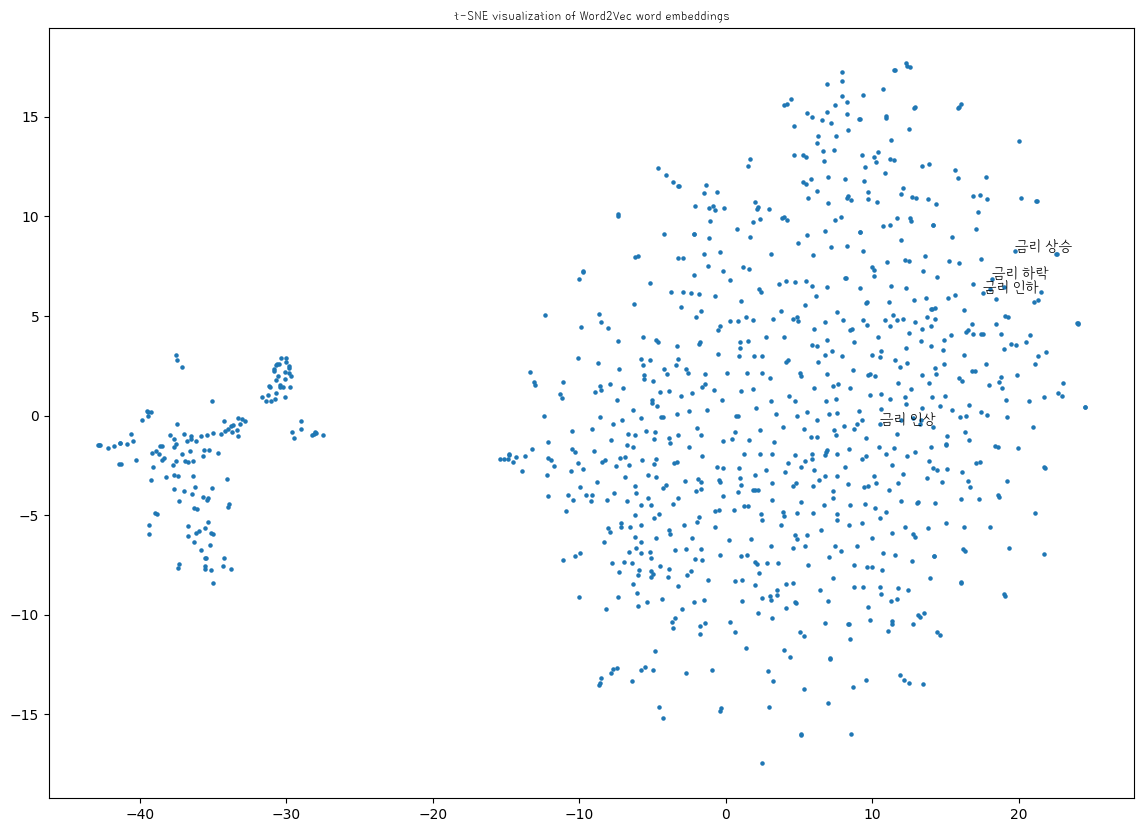

In [4]:
import matplotlib.pyplot as plt
import gensim
import numpy as np
from sklearn.manifold import TSNE
from matplotlib import font_manager
import warnings
# 'findfont' 경고 메시지 숨기기
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib.font_manager')

# 모델 불러오기
model = gensim.models.Word2Vec.load("ngram2vec.model")

# 단어 리스트 가져오기 (가장 많이 등장한 1000개 단어 선택)
words = list(model.wv.index_to_key)[:1000]
word_vectors = np.array([model.wv[word] for word in words])  # 벡터 추출

# t-SNE로 2차원 축소
tsne = TSNE(n_components=2, random_state=42, perplexity=40, n_iter=3000)
word_vectors_2d = tsne.fit_transform(word_vectors)

# 업로드한 폰트 경로 지정
font_path = '/content/drive/MyDrive/Colab Notebooks/강원교육모두 Light.ttf'  # 업로드한 폰트 파일 경로

# 폰트 프로퍼티 설정
font_prop = font_manager.FontProperties(fname=font_path)

# 시각화
plt.figure(figsize=(14, 10))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], s=5)


# 특정 단어들 선택
words_to_plot = ['금리 인상', '금리 인하', '금리 상승', '금리 하락']
# 일부 단어에 라벨 표시
for i, word in enumerate(words_to_plot):
    plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]), fontsize=12, fontproperties=font_prop)

plt.title("t-SNE visualization of Word2Vec word embeddings", fontproperties=font_prop)
plt.show()

## 5. 최적화
    5-1. 우리가 처리해야 할 데이터는 text만 총 25만 개 정도
    5-2. 어떻게 하면 멈추거나 메모리 문제 없이 제대로 해결할 수 있을까 -> 지금 모델로는 빠르게 돌리지는 못해도 메모리 충돌이나 과다는 없었음


In [ ]:
# 계속해서 token불러오고 학습시키고... 지금 처럼 반복하면 Ram에 큰 무리는 없을 것
# min_count는 기본 5로 설정해야 메모리 문제 X, 그리고 가장 많은 수의 데이터로 시작하고 있으니 중요도가 많이 떨어지는 단어만 걸러질 것이라고 추측함

# 예측 결과가 나쁘지 않다면? -> 이대로 먼저 ngram2vec모델을 구글 드라이브에 저장

### 6. 벡터를 활용한 분류 모델 제작
    6-1. 어떤 모델을 사용하는가? (논문을 다시 읽어보고 구축하기)
    - 딥러닝 분류모델 다시 복습 & 공부
    - propagation을 수행할 수 있는 모델을 찾아서 내가 직접 구축해 보기
    6-2. 최적화를 다시 해야 할 것인가? (Deep Learning Model의 메모리 문제가 있다면)
